In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack
from collections import Counter

import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
path_data = "C:/Users/NORA/hlca_core.h5ad"
adata = anndata.read_h5ad(path_data, backed = 'r')

In [4]:
path_results = "verif_plots/"

if not os.path.exists(path_results):
    os.makedirs(path_results)

In [5]:
embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
cell_type_labels = adata.obs['ann_level_4'].astype(str)
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
classes = sorted(set(cell_type_labels))

In [6]:
with open('../2. Main classification experiment/helper_pickle_files/color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

In [7]:
proportions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Modified training function:

In [8]:
def train_clf_and_predict_with_exclusion(X, y, sex_labels, individual_labels, proportion_female, excluded_donors, classifier='knn', k = 30):
    '''
    Modified train and prediction function that excludes some donors from the training set.
    '''
    
    np.random.seed(42)
    
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    individual_labels_male = np.array(individual_labels)[male_indices]

    X_female = X[female_indices]
    y_female = y[female_indices]
    individual_labels_female = np.array(individual_labels)[female_indices]
    
    X_female_train, X_female_test, y_female_train, y_female_test, ind_female_train, ind_female_test = train_test_split(
        X_female, y_female, individual_labels_female, test_size=0.2, stratify=y_female, random_state=42)

    # Compute what to pass to test_size to get equal test set size to the female set
    male_proportion = X_female_test.shape[0] / X_male.shape[0]

    # Split males
    X_male_train, X_male_test, y_male_train, y_male_test, ind_male_train, ind_male_test = train_test_split(
        X_male, y_male, individual_labels_male, test_size=male_proportion, stratify=y_male, random_state=42)

    print(f'length male female: {len(X_male_train)}, {len(X_female_train)}')
    # Exclude donors from male and female train sets
    X_male_train, y_male_train, ind_male_train = exclude_donors_by_id(X_male_train, y_male_train, ind_male_train, excluded_donors)
    X_female_train, y_female_train, ind_female_train = exclude_donors_by_id(X_female_train, y_female_train, ind_female_train, excluded_donors)
    print(f'length male female after excl: {len(X_male_train)}, {len(X_female_train)}')
    
    # merge training sets back together
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]
    ind_train = np.concatenate([ind_male_train, ind_female_train])

    # Select female cells based on proportion_female
    selected_indices = fixed_select_indices_by_proportion(sex_labels_train, proportion_female)
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    ind_selected = ind_train[selected_indices]

    # Initialize classifier
    if classifier == 'knn':
        clf = KNeighborsClassifier(n_neighbors=k)
    elif classifier == 'rf':
        clf = RandomForestClassifier(n_jobs=-1)
        
    print('initialized classif!', flush = True)
    # Train
    clf.fit(X_selected, y_selected)
       
    print('done training!', flush = True)
    
    # Predict
    male_pred = clf.predict(X_male_test)
    female_pred = clf.predict(X_female_test)

    # Compute donor contribution scores
    donor_train_counts = Counter(ind_selected)
    male_contrib_scores = {donor: donor_train_counts[donor] / len(ind_selected) for donor in np.unique(ind_male_test)}
    female_contrib_scores = {donor: donor_train_counts[donor] / len(ind_selected) for donor in np.unique(ind_female_test)}

    return male_pred, y_male_test, female_pred, y_female_test, ind_male_test, ind_female_test, male_contrib_scores, female_contrib_scores


def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(42)
    sex_labels_series = pd.Series( (el for el in sex_labels) )
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])
    

def exclude_donors_by_id(X_train, y_train, ind_train, excluded_donors):
    final_indices = np.isin(ind_train, excluded_donors, invert=True)
    return  X_train[final_indices], y_train[final_indices], ind_train[final_indices]

Function to evaluate results for each donor:

In [9]:
def evaluate_accuracy_per_donor(predictions, true_labels, donor_ids):
    """
    Computes accuracy per donor.
    
    Parameters:
    - predictions: prediction for the test set
    - true_labels: true labels for the test se 
    - donor_ids: list of donor IDs corresponding to each entry in the test set
    
    Returns:
    - donor_accuracy: dictionary with donor IDs as keys and their accuracy scores as values
    """
    donor_accuracy = {}
    
    unique_donors = np.unique(donor_ids)
    
    for donor in unique_donors:
        # get indices for current donor and subset predictions and true labels
        donor_indices = np.where(donor_ids == donor)[0]
        donor_predictions = predictions[donor_indices]
        donor_true_labels = true_labels[donor_indices]
        
        # calculate accuracy, store in dictionary
        donor_accuracy[donor] = accuracy_score(donor_true_labels, donor_predictions)
    
    return donor_accuracy

Exclude 1/3 of donors:

In [10]:
np.random.seed(42)
male_results = {}
female_results = {}

# select donors to exclude
unique_donors = np.unique(individual_labels)
num_excluded_donors = int(len(unique_donors) * (1/3))
excluded_donors = np.random.choice(unique_donors, size=num_excluded_donors, replace=False)

for prop in proportions:
    print(f"prop: {prop}")
    # train, store predictions, true labels, donor IDs, contribution scores
    male_pred, y_male_test, female_pred, y_female_test, ind_male_test, ind_female_test, male_contrib_scores, female_contrib_scores = train_clf_and_predict_with_exclusion(
        embedding, cell_type_labels, sex_labels, individual_labels, prop, excluded_donors)
    
    # calc donor accuracy for male and female donors
    male_donor_accuracy = evaluate_accuracy_per_donor(male_pred, y_male_test, ind_male_test)
    female_donor_accuracy = evaluate_accuracy_per_donor(female_pred, y_female_test, ind_female_test)
    
    # store results for current proportion in separate dictionaries
    male_results[prop] = {
        "accuracy": male_donor_accuracy,
        "contribution": male_contrib_scores
    }
    female_results[prop] = {
        "accuracy": female_donor_accuracy,
        "contribution": female_contrib_scores
    }

prop: 0.0
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.1
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.2
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.3
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.4
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.5
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.6
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!
done training!
prop: 0.7
length male female: 307516, 184952
length male female after excl: 154098, 146869
initialized classif!

Plots:

In [11]:
def plot_donor_accuracies(results_dict, sex, proportions):
    main_color = 'red' if sex == 'female' else 'dodgerblue'
    exclude_color = 'purple' if sex == 'female' else 'green'
    
    # select proportions based on sex
        # at prop = 0 none of the female donors contribute, at prop = 1 none of the male donors do 
        # => exclude from plot
    if sex == 'female':
        plot_proportions = [prop for prop in proportions if prop >= 0.1]
    else:
        plot_proportions = [prop for prop in proportions if prop <= 0.9]
    
    plt.figure(figsize=(12, 8))
    
    for donor_id in results_dict[plot_proportions[0]]['accuracy'].keys():
        # extract accuracy and contribution
        accuracies = [results_dict[prop]['accuracy'].get(donor_id, np.nan) for prop in plot_proportions]
        contributions = [results_dict[prop]['contribution'].get(donor_id, 0) for prop in plot_proportions]

        # differentiate between contributing and non-contributing
        color = main_color if any(contributions) else exclude_color

        # plot
        plt.plot(plot_proportions, accuracies, color=color, marker='o', linestyle='-', alpha=0.5)
    
    plt.title(f'Accuracy Across Proportions for {sex.capitalize()} Donors')
    plt.xlabel('% of Female Cells in Training Set')
    plt.ylabel('Performance (Accuracy)')
    plt.xticks(plot_proportions)
    plt.grid(True)

    # legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=main_color, lw=2, label='Contributed to Training Set'),
        Line2D([0], [0], color=exclude_color, lw=2, label='Excluded from Training Set')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()

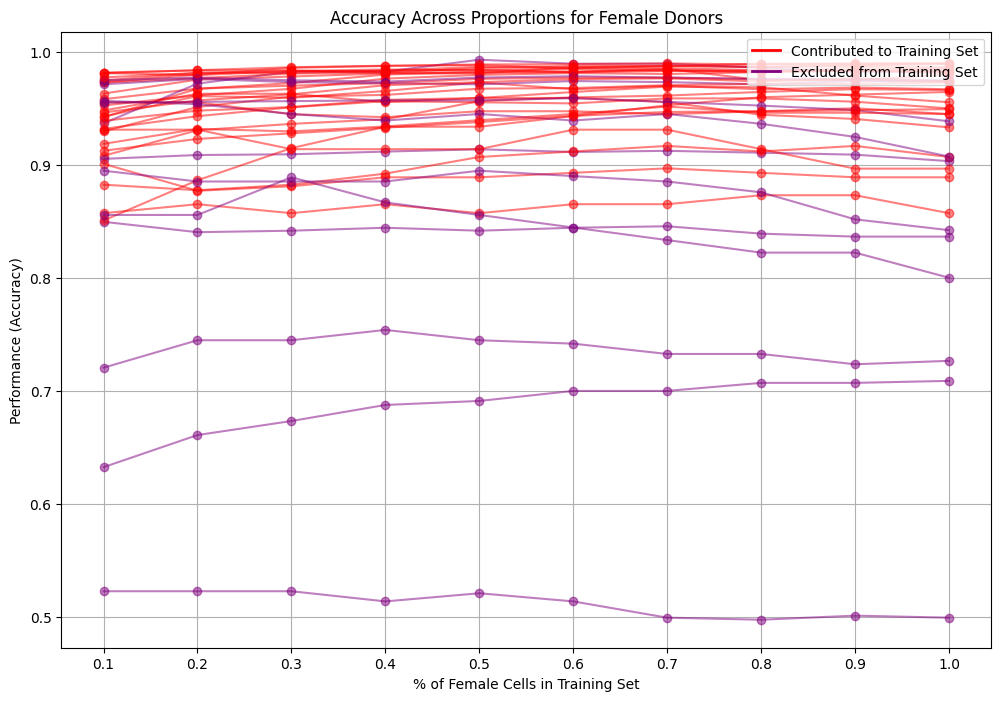

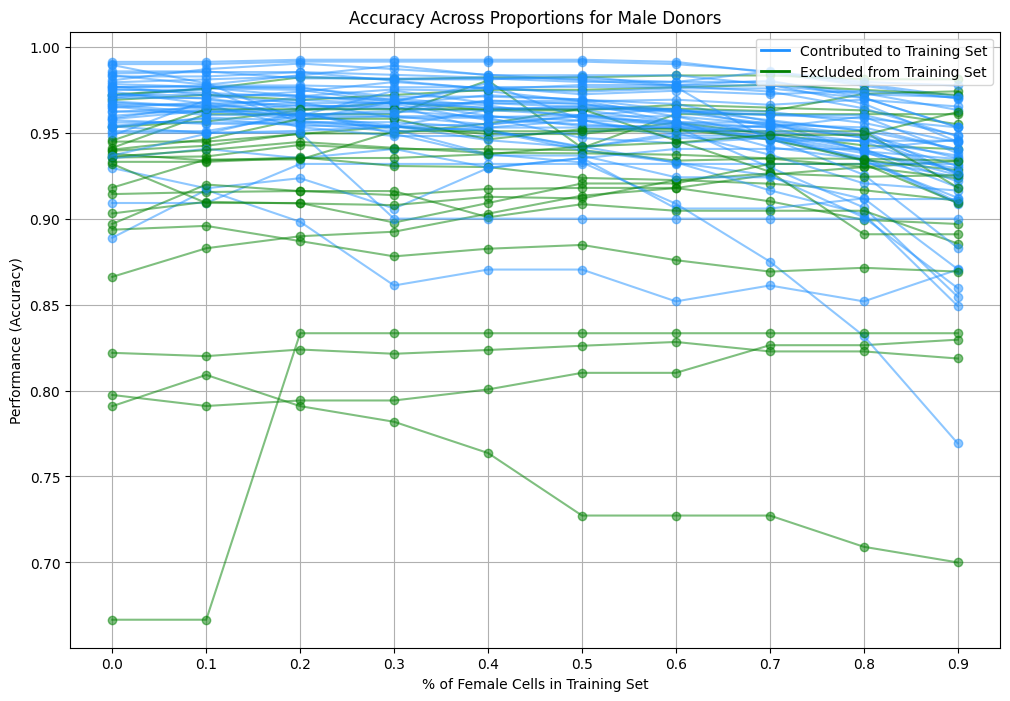

In [12]:
plot_donor_accuracies(female_results, 'female', proportions)
plot_donor_accuracies(male_results, 'male', proportions)

Average performance of contributing vs non-contributing:

In [13]:
def plot_avg_performance(results_dict, sex, proportions, save = False):
    main_color = 'red' if sex == 'female' else 'dodgerblue'
    exclude_color = 'purple' if sex == 'female' else 'green'
    
    if sex == 'female':
        plot_proportions = [prop for prop in proportions if prop >= 0.1]
    else:
        plot_proportions = [prop for prop in proportions if prop <= 0.9]

    avg_contrib_performance = []
    avg_exclude_performance = []
    var_contrib_performance = []
    var_exclude_performance = []

    for prop in plot_proportions:
        accuracies = results_dict[prop]['accuracy']
        contributions = results_dict[prop]['contribution']
        
        contrib_accuracies = [acc for donor, acc in accuracies.items() if contributions[donor] > 0]
        exclude_accuracies = [acc for donor, acc in accuracies.items() if contributions[donor] == 0]
        
        # calc averages and variances
        avg_contrib_performance.append(np.mean(contrib_accuracies) if contrib_accuracies else np.nan)
        avg_exclude_performance.append(np.mean(exclude_accuracies) if exclude_accuracies else np.nan)
        
        var_contrib_performance.append(np.var(contrib_accuracies) if contrib_accuracies else np.nan)
        var_exclude_performance.append(np.var(exclude_accuracies) if exclude_accuracies else np.nan)

    # convert variance to standard deviation
    std_contrib_performance = np.sqrt(var_contrib_performance)
    std_exclude_performance = np.sqrt(var_exclude_performance)
    

    plt.figure(figsize=(12, 10))
    
    # contributing donors
    plt.plot(plot_proportions, avg_contrib_performance, color=main_color, label='Contributing', marker='o')
    plt.fill_between(plot_proportions,
                     np.array(avg_contrib_performance) - std_contrib_performance,
                     np.array(avg_contrib_performance) + std_contrib_performance,
                     color=main_color, alpha=0.2)
    
    # non-contributing donors
    plt.plot(plot_proportions, avg_exclude_performance, color=exclude_color, label='Excluded', marker='o')
    plt.fill_between(plot_proportions,
                     np.array(avg_exclude_performance) - std_exclude_performance,
                     np.array(avg_exclude_performance) + std_exclude_performance,
                     color=exclude_color, alpha=0.2)

    plt.title(f'Average accuracy for {sex} donors', fontsize = 26)
    plt.xlabel('% female samples', fontsize = 22)
    plt.ylabel('Accuracy scores', fontsize = 22)
    plt.xticks(plot_proportions, fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylim(0.70, 1.02)
    plt.grid(True)

    plt.legend(loc='lower right', fontsize = 20, title = "In training set", title_fontsize = 21)

    if save:
        plt.savefig(f"{path_results}/Naive_bias_average_acc_{sex}")
    plt.show()

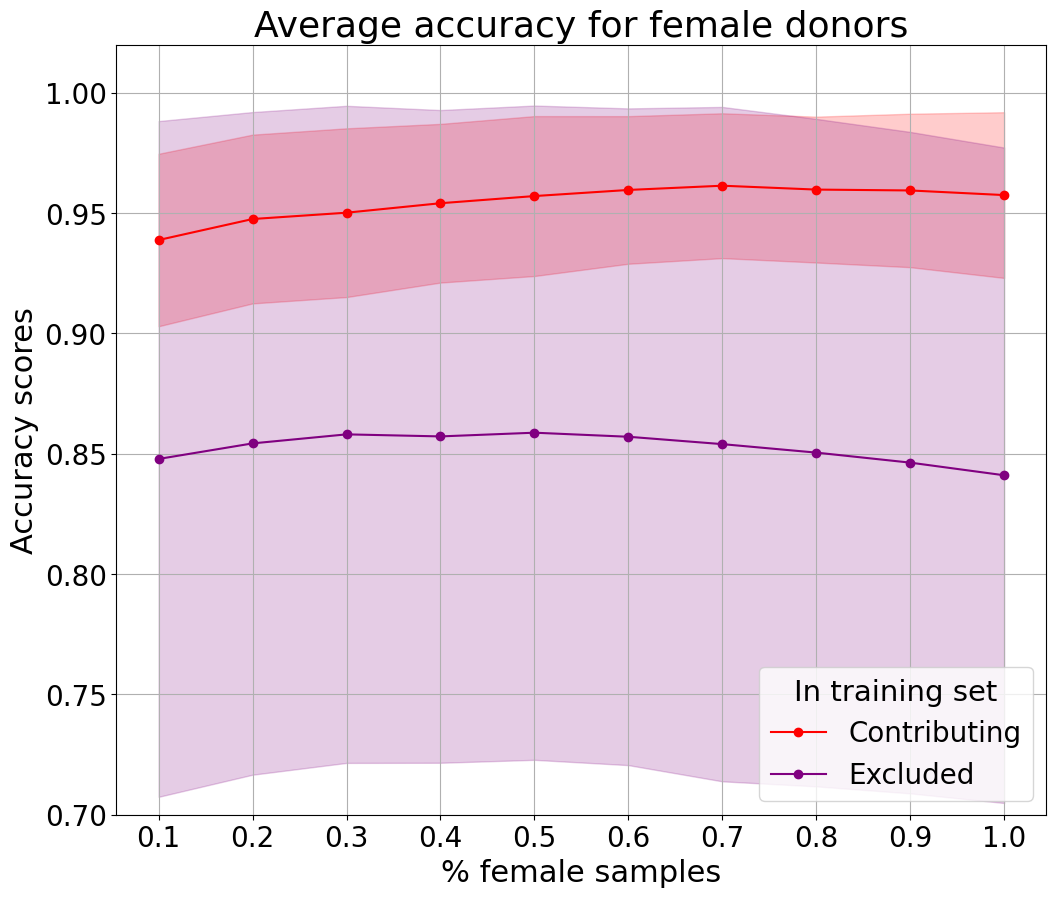

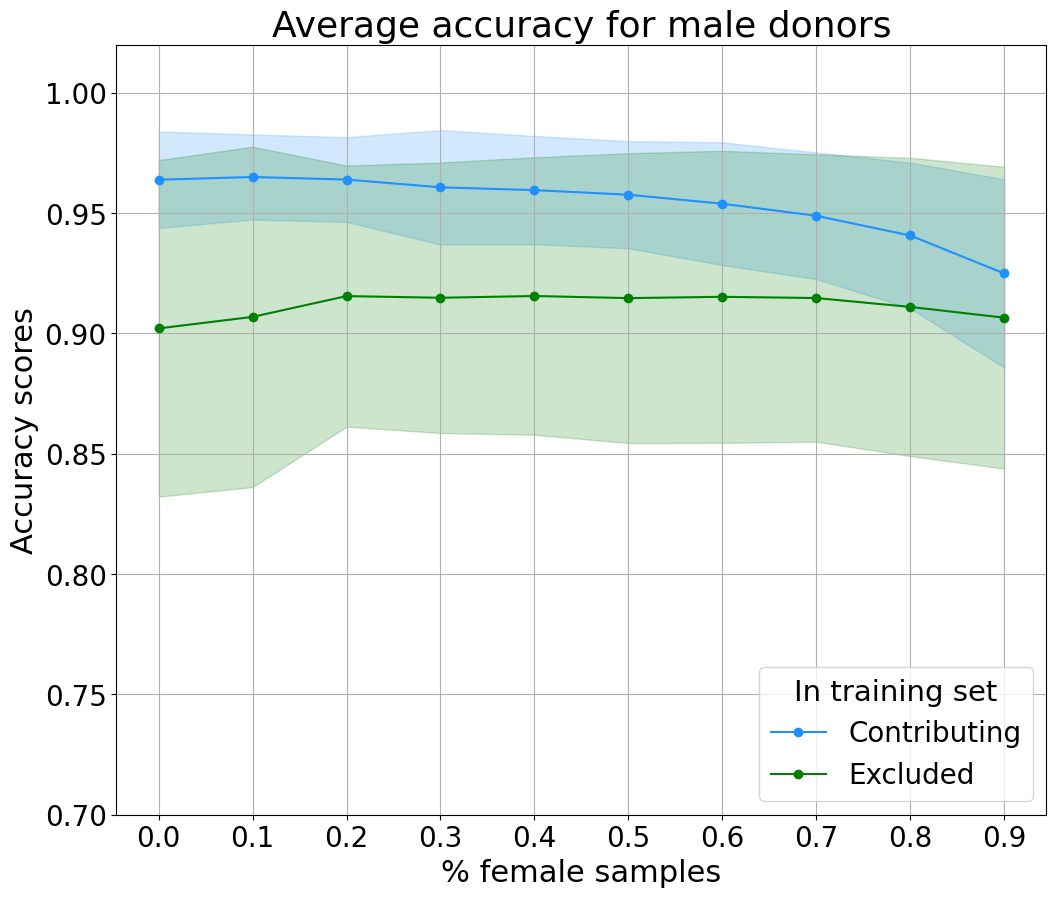

In [14]:
plot_avg_performance(female_results, 'female', proportions, save = True)
plot_avg_performance(male_results, 'male', proportions, save = True)